In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import multiprocessing
import sys
import logging

tf.get_logger().setLevel(logging.ERROR)

sys.path.append('../src/')

physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

np.set_printoptions(suppress=True)

In [2]:
# import modules
from cnn.simulator import Simulator

from cnn.models import ConvNet
from cnn.losses import CustomLoss
from cnn.metrics import CustomAUC
from cnn.preprocessing import LabelEncoder
from cnn.data_generators import DataGenerator

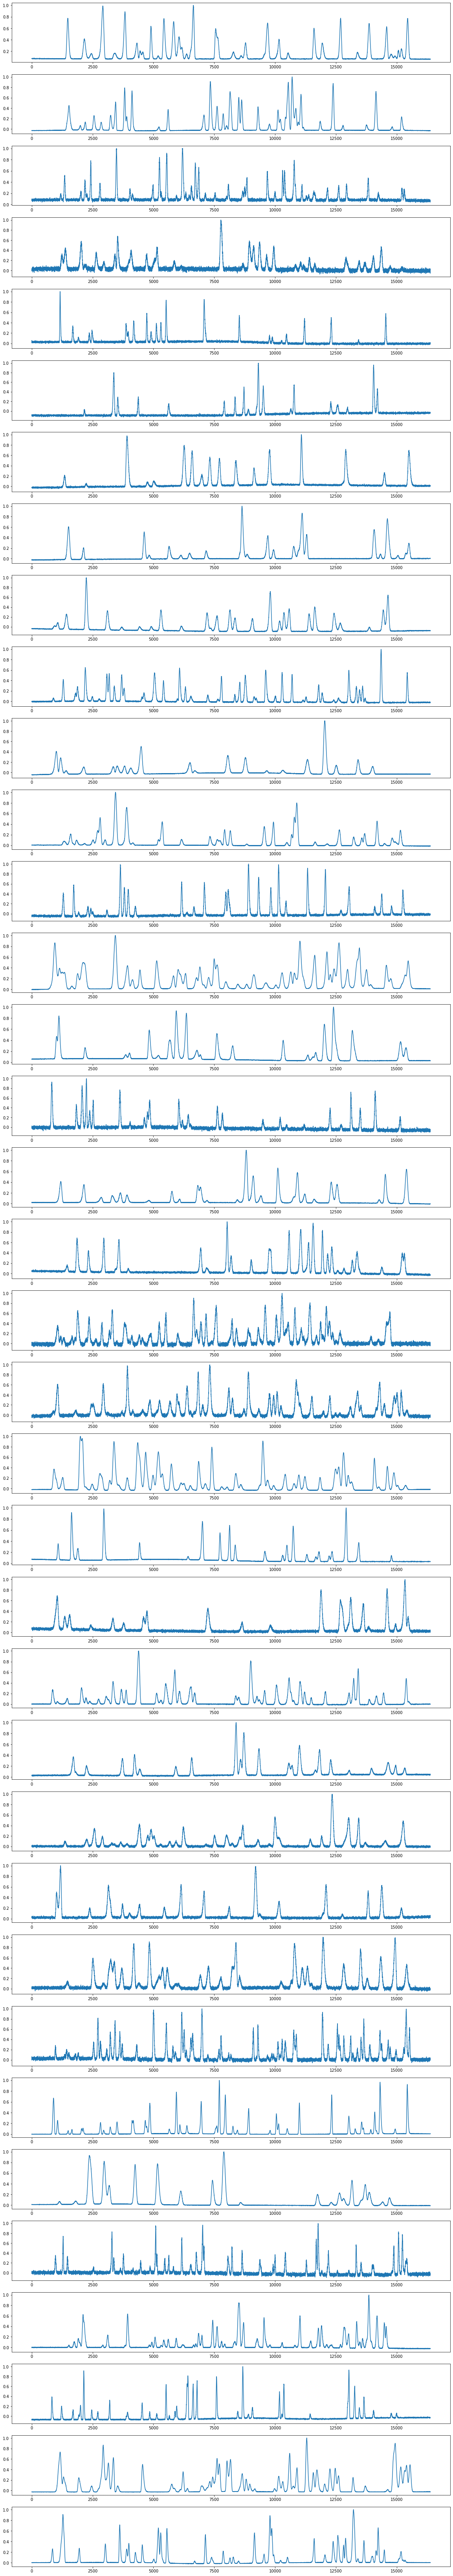

In [5]:
simulator_train = Simulator()

fig, axes = plt.subplots(36, 1, figsize=(20, 120))
for i in range(36):
    out = simulator_train._generate_example(i+100)
    axes.reshape(-1)[i].plot(out['chromatogram'])

In [6]:


LEARNING_RATE = 5e-4
LEARNING_RATE_DECAY = 0.2
NUM_CLASSES = 3
NUM_WINDOWS = 512

loss_fn = CustomLoss(NUM_CLASSES, 1.0, 1.0, 1.0)
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
metrics = [CustomAUC(NUM_CLASSES)]

simulator_train = Simulator()

simulator_test = Simulator()

label_encoder = LabelEncoder(NUM_WINDOWS)

train_generator = DataGenerator(
    np.arange(0, 100_000), 
    simulator=simulator_train, 
    label_encoder=label_encoder,
    shuffle=True
)
validation_generator = DataGenerator(
    np.arange(100_000, 110_000), 
    simulator=simulator_test, 
    label_encoder=label_encoder,
)
test_generator = DataGenerator(
    np.arange(110_000, 120_000), 
    simulator=simulator_test, 
    label_encoder=label_encoder,
)


model = ConvNet(
    filters=[128, 128, 256, 256, 512],
    kernel_sizes=[9, 9, 9, 9, 9],
    pool_type='max',
    input_shape=(16384, 1),
    output_shape=(NUM_WINDOWS, NUM_CLASSES)
)
model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)

In [33]:
for _ in range(2):
    
    model.fit(train_generator)
    #out = model.evaluate(validation_generator, use_multiprocessing=False, workers=8)
    
    current_lr = model.optimizer.learning_rate
    model.optimizer.learning_rate.assign(current_lr * (1 - LEARNING_RATE_DECAY))
    
    
    

3125/3125 [==============================] - 1096s 351ms/step - loss: 0.8424 - AUC: 0.9942


In [34]:
prediction = model.predict(test_generator, verbose=1)

313/313 [==============================] - 109s 350ms/step


In [37]:
for i in range(313):
    true = test_generator.__getitem__(i)
    if true[1][0][:, 0].sum() < 24:
        print(i)

3
4
20
23
27
48
63
67
72
77
82
93
99
104
105
107
110
112
119
128
153
164
187
201
221
244
248
250
260
263
268
272
277
296
299
308
311


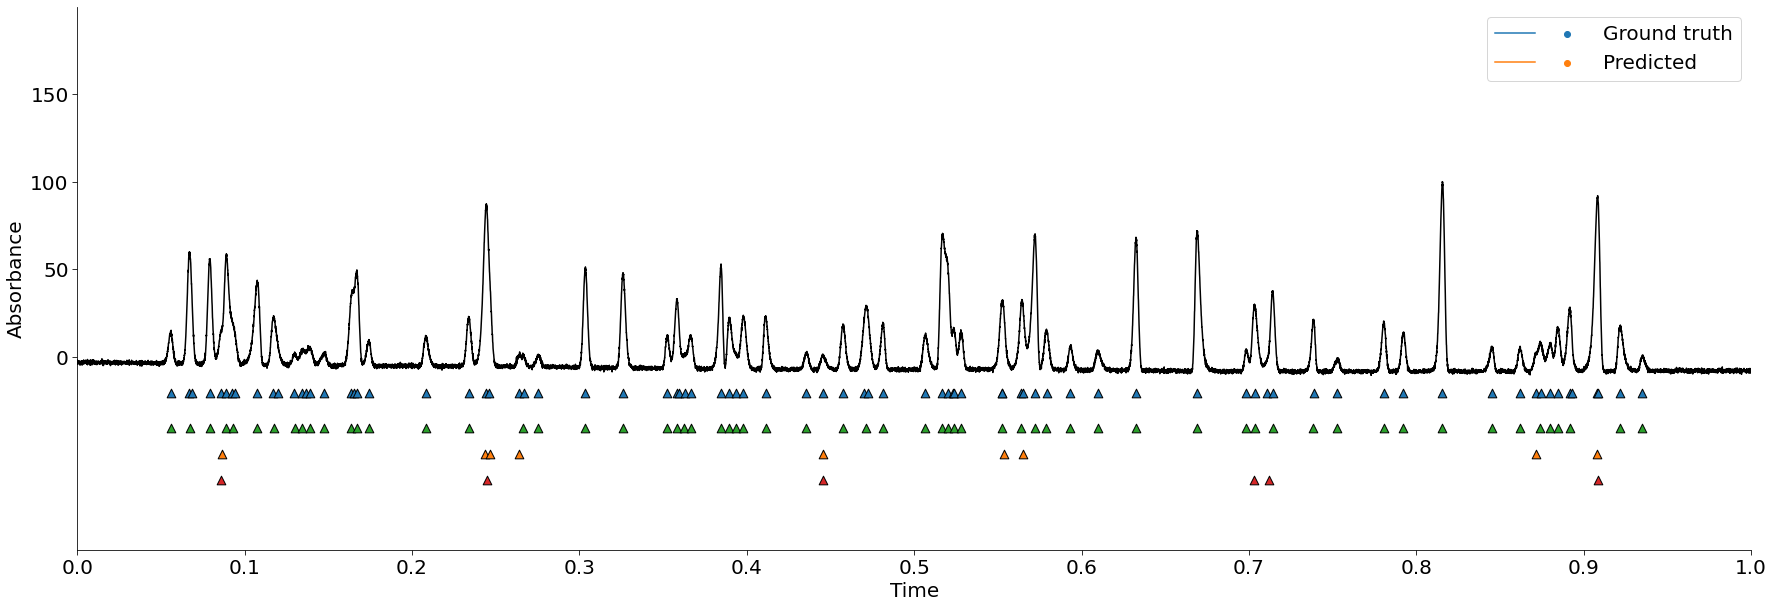

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(30, 10))

x_lim = [0.0, 1.0 + 1e-7]

ID = 12

true_move = {0: (0.0, 0), 1: (0, 0), 2: (0, 0), 3: (0, 0), 4: (0, 0), 
             5: (0, 0), 6: (0, 0), 7: (0, 0), 8: (0, 0), 9: (0, 0), 
             10: (0, 0), }

pred_move = {0: (0, 0), 1: (0, 0), 2: (0, 0), 3: (0, 0), 4: (0, 0), 
             5: (0, 0), 6: (0.03, 0), 7: (-0.005, 15), 8: (0, 0), 9: (0.03, 0), 
             10: (0, 15), }


# GROUND TRUTH
true = test_generator.__getitem__(ID)

pred = prediction[ID*validation_generator.batch_size]

probs, locs, areas = label_encoder.decode(pred, 0.2)

x = true[0][0] * 100
y = true[1][0]
#x = x * 255

gt = label_encoder.decode(y)

j, k = 0, 0
for i, y_sample in enumerate(y):
    if y_sample[0] == 1:
        
        index = int(gt[1][k] * 16384)
        height = max(x[index:index+1]) + 5
        
        if x_lim[0] < gt[1][k] < x_lim[1]: 
            ax.scatter(gt[1][k], np.min(x)-10, c='C0', s=75, marker='^', edgecolor='black')
            #ax.axvline(gt[1][k], linestyle='--')
            #if k % 3 == 0:
            #ax.text(x=gt[1][k]-0.005 * x_lim[1], y=height+17, s=f"{gt[2][k]:.3f}", color="C0", fontsize=20)
        
        k += 1
        
    if pred[i][0] > 0.2:
        index = int(gt[1][k-1] * 16384)
        height = max(x[index:index+1]) + 5
        
        if x_lim[0] < locs[j] < x_lim[1]: 
            
            if pred[i][0] > 0.9:
                ax.scatter(locs[j], np.min(x)-30, c='C2', s=75, marker='^', edgecolor='black')
            elif pred[i][0] > 0.7:
                ax.scatter(locs[j], np.min(x)-45, c='C1', s=75, marker='^', edgecolor='black')
            elif pred[i][0] > 0.2:
                ax.scatter(locs[j], np.min(x)-60, c='C3', s=75, marker='^', edgecolor='black')
            #if k % 3 == 0:
            #ax.text(x=locs[j]-0.0075 * x_lim[1], y=np.min(x)-85, s=f'{probs[j]:.3f}', rotation=-90, fontsize=12)
            #ax.text(x=locs[j]-0.005 * x_lim[1], y=height, s=f"{areas[j]:.3f}", color='C1', fontsize=20)

        j += 1
        

        
ax.plot(np.linspace(0, 1, simulator_test.resolution), x, c='black')
        
ax.scatter([None],[None], c='C0', label='Ground truth')
ax.scatter([None],[None], c='C1', label='Predicted')
ax.plot([None],[None], c='C0', label=' ')
ax.plot([None],[None], c='C1', label=' ')


ax.set_ylabel('Absorbance', fontsize=20)
ax.set_xlabel('Time', fontsize=20)
ax.set_ylim(np.min(x)-100, np.max(x)+100);
ax.set_xlim(*x_lim)
ax.tick_params(axis='both', length=5, labelsize=20)

start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 0.1))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(0, end, 50))
ax.legend(columnspacing=-0.5, fontsize=20, ncol=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#ax.set_xlim(0.05, 0.37)
#plt.savefig('peak_detection_2.png', dpi=300)

In [37]:
import scipy.interpolate
import glob
import pandas as pd

In [38]:
def apply_interpolation(x, y, target_size):
    '''
    Resizes a chromatogram to a given size/resolution
    '''
    f = scipy.interpolate.interp1d(x, y)
    xnew = np.linspace(x.min(), x.max(), target_size)
    ynew = f(xnew)
    return xnew, ynew

def apply_interpolation(y, target_size):
    '''
    Resizes a chromatogram to a given size/resolution
    '''
    x = np.linspace(0, 1, len(y))
    f = scipy.interpolate.interp1d(x, y)
    xnew = np.linspace(0, 1, target_size)
    ynew = f(xnew)
    return ynew

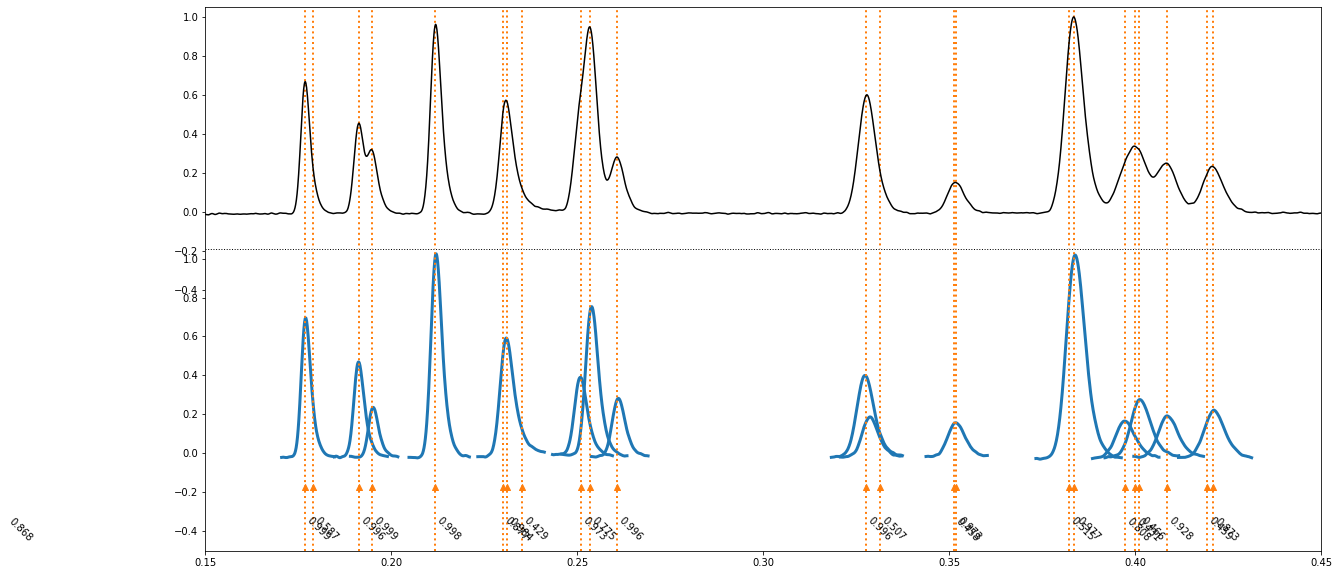

In [42]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

csv = pd.read_csv('../input/chrom_1/ISO_ALL_F10.CSV', header=None, sep='\t', encoding='utf-16')
x = csv[1].values
x = apply_interpolation(x, 16384)
x_max = x.max()
x = x[None, :, None] / x_max
out = model.predict(x)[0]

for c in glob.glob('../input/chrom_1/ISO_[0-9]*'):
    csv = pd.read_csv(c, header=None, sep='\t', encoding='utf-16')
    d = csv[1].values
    d = apply_interpolation(d, 16384)
    d = d / x_max
    idx = np.where(d > 0.05)[0]
    s, e = idx[0], idx[-1]
    ex = 50 + int((100 * np.linspace(0, 1, 16384)[s]))
    axes[1].plot(np.linspace(0, 1, 16384)[s-ex:e+ex], d[s-ex:e+ex], c='C0', linewidth=3)
    
    
probs, locs, areas = label_encoder.decode(out, 0.4)
for i, (p, l, a) in enumerate(zip(probs, locs, areas)):
    axes[1].scatter(l, np.min(x)-0.15, marker='^', c=f'C1')
    axes[1].text(x=l, y=-0.45, s=f'{p:.3f}', rotation=-45)
    axes[1].axvline(l, c='C1', linestyle=':', linewidth=2)
    axes[0].axvline(l, c='C1', linestyle=':', linewidth=2)
    
axes[0].plot(np.linspace(0, 1, 16384), x[0, :, 0], c='black', linestyle='-')

axes[0].set_xlim(0.15, 0.45)
axes[1].set_xlim(0.15, 0.45)

axes[0].tick_params(
    axis='x', which='both', bottom=False, top=False, labelbottom=False)
axes[1].spines['top'].set_visible(False)
axes[1].axhline(1.05, c='black', linewidth=1, linestyle=':')
axes[0].set_ylim(-0.5, 1.05)
axes[1].set_ylim(-0.5, 1.05)
plt.subplots_adjust(hspace=-0.2)

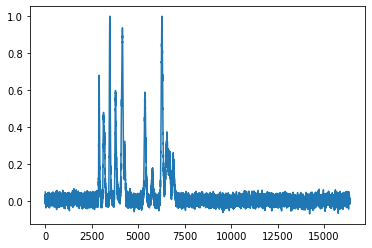

In [25]:
x = x[0, :, 0]
plt.plot(x)

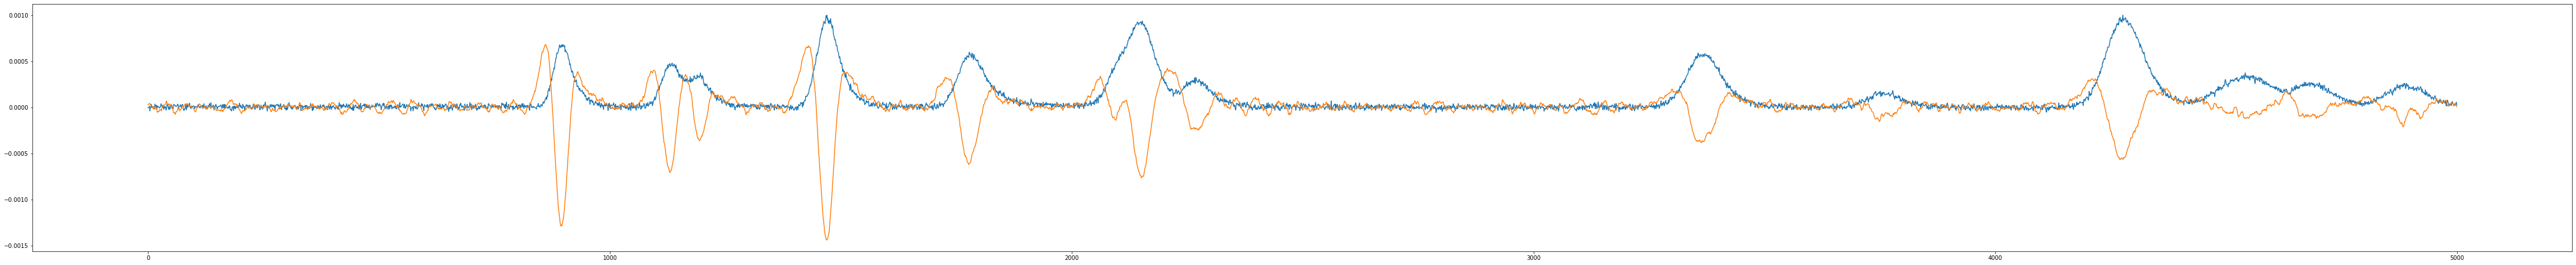

In [26]:
import scipy.signal

plt.figure(figsize=(80, 8))
deriv = scipy.signal.savgol_filter(x, window_length=51, polyorder=2, deriv=2)

plt.plot(x[2000:7000] * 0.001)
plt.plot(deriv[2000:7000])

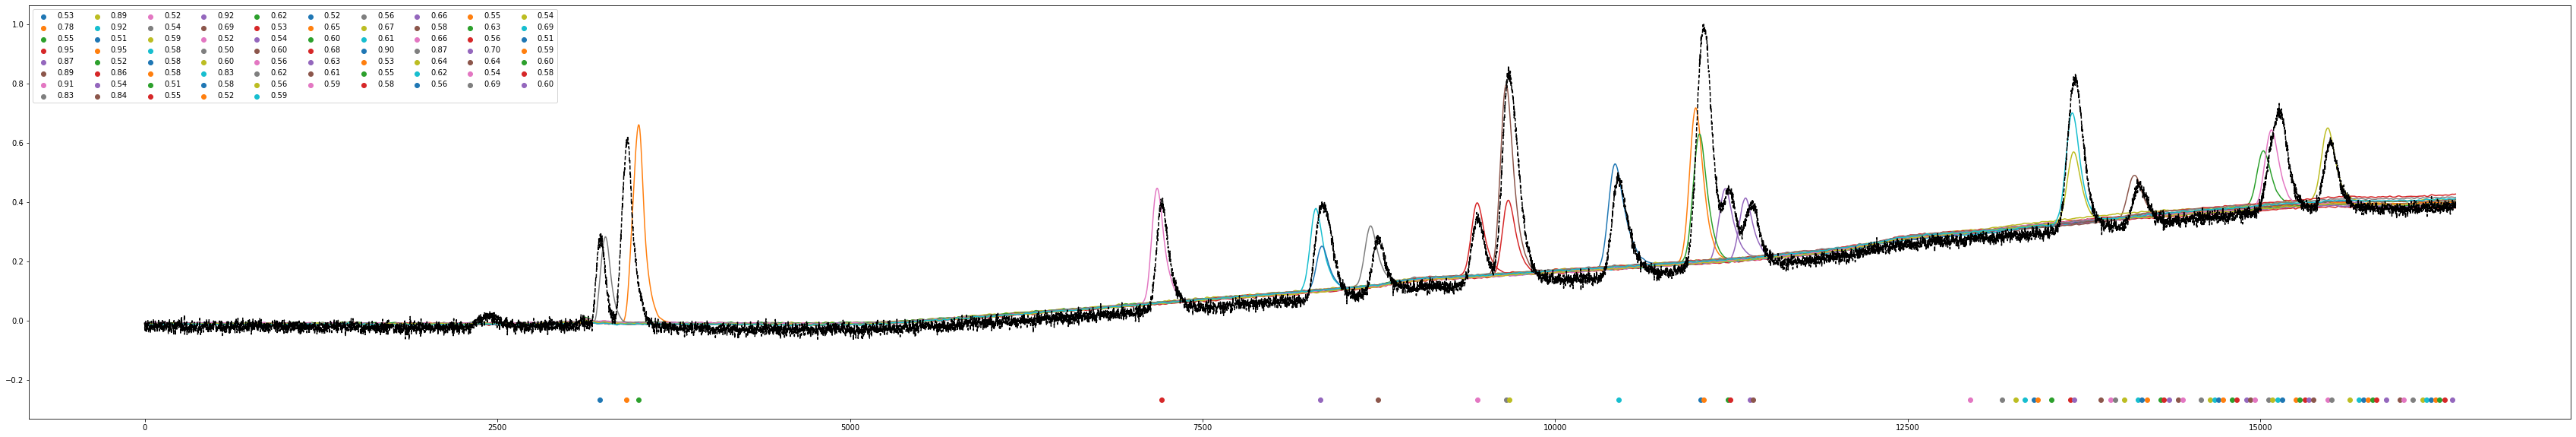

In [27]:
plt.figure(figsize=(60, 10))


csv = pd.read_csv('../input/chrom_1/GRA_ALL_F160.CSV', header=None, sep='\t', encoding='utf-16')
x = csv[1].values
x = apply_interpolation(x, 16384)
x_max = x.max()
x = x[None, :, None] / x_max
out = model.predict(x)[0]

for c in glob.glob('../input/chrom_1/GRA_[0-9]*'):
    csv = pd.read_csv(c, header=None, sep='\t', encoding='utf-16')
    d = csv[1].values
    d = apply_interpolation(d, 16384)
    d = d / x_max
    plt.plot(d)
    
    
probs, locs, areas = label_encoder.decode(out, 0.5)
for i, (p, l, a) in enumerate(zip(probs, locs, areas)):
   # print(p, l, a)
    plt.scatter(l * 16384, np.min(x)-0.2, c=f'C{i}', label=f'{p:.2f}')
    #plt.text(x=l * 16384, y=np.min(x)-0, s=f'{p:.2f}', rotation=-45)
    #plt.plot([l-w/2, l+w/2], [.080+(i*.015), .080+(i*.015)], color=f'C{i}')
    #plt.plot([l, l], [0, a], color='C0', linewidth=4, linestyle=':')
    #plt.plot([l-s/2, l+s/2], [0, 0], color='C0', linewidth=4, linestyle=':')
    
    #index = int(g * 16384)
    #height = max(x[index-10:index+10]) + 20
    #plt.text(x=g-0.005, y=height, s=f"{a:.2f}", color='C1', fontsize=14)

plt.legend(loc=2, ncol=10)
plt.plot(x[0, :, 0], c='black', linestyle='--')


In [13]:
for _ in range(6):
    
    model.fit(train_generator, use_multiprocessing=False, workers=8)
    #out = model.evaluate(validation_generator, use_multiprocessing=False, workers=8)
    
    current_lr = model.optimizer.learning_rate
    model.optimizer.learning_rate.assign(current_lr * (1 - LEARNING_RATE_DECAY))
    
    
    

3125/3125 [==============================] - 789s 252ms/step - loss: 1.2651 - AUC: 0.9840


In [221]:
encoder.num_windows

1024

In [31]:
true[0]

array([[[-32.18758935],
        [-32.19772819],
        [-36.08065433],
        ...,
        [-50.34018911],
        [-44.96113467],
        [-44.19971608]],

       [[-48.57613598],
        [-47.73288442],
        [-50.57540847],
        ...,
        [-45.42672455],
        [-43.87481871],
        [-42.60541207]],

       [[-40.06055921],
        [-40.87676027],
        [-46.33913848],
        ...,
        [  1.68150951],
        [  3.21576122],
        [  0.47553527]],

       ...,

       [[191.3946352 ],
        [188.26387053],
        [189.69187009],
        ...,
        [ -2.18885001],
        [ -0.99118109],
        [ -2.59180514]],

       [[ -3.06356074],
        [ -3.46213054],
        [ -3.99050632],
        ...,
        [ -3.72514013],
        [ -4.44954436],
        [ -6.81041236]],

       [[ -3.57863307],
        [ -6.94536456],
        [ -6.3988929 ],
        ...,
        [-13.59781514],
        [-10.73318887],
        [-13.97258437]]])

In [62]:
class TemperatureSoftmaxCalibration(tf.keras.Model):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.temperature = tf.Variable(1., trainable=True)
    
    def call(self, inputs):
        z = inputs / self.temperature
        p = tf.nn.sigmoid(z)
        return p
    
# class TemperatureSoftmaxCalibration(tf.keras.Model):
    
#     def __init__(self, **kwargs):
#         super().__init__(**kwargs)
#         self.a = tf.Variable(1., trainable=True)
#         self.b = tf.Variable(0., trainable=True)
    
#     def call(self, inputs):
#         z = self.a * inputs + self.b
#         p = tf.nn.sigmoid(z)
#         return p
    
calib = TemperatureSoftmaxCalibration()

calib.compile(loss='bce', optimizer=tf.keras.optimizers.Adam(1e-2))

predictions = model.predict(x_validation)

preds = predictions[:, :, 0]
preds = tf.math.log(preds/(1-preds+1e-7))

trues = y_validation[:, :, 0],

calib.fit(preds, trues, epochs=100, verbose=2)

Epoch 1/100
32/32 - 0s - loss: 0.0744
Epoch 2/100
32/32 - 0s - loss: 0.0744
Epoch 3/100
32/32 - 0s - loss: 0.0744
Epoch 4/100
32/32 - 0s - loss: 0.0744
Epoch 5/100
32/32 - 0s - loss: 0.0744
Epoch 6/100
32/32 - 0s - loss: 0.0744
Epoch 7/100
32/32 - 0s - loss: 0.0744
Epoch 8/100
32/32 - 0s - loss: 0.0744
Epoch 9/100
32/32 - 0s - loss: 0.0744
Epoch 10/100
32/32 - 0s - loss: 0.0744
Epoch 11/100
32/32 - 0s - loss: 0.0744
Epoch 12/100
32/32 - 0s - loss: 0.0744
Epoch 13/100
32/32 - 0s - loss: 0.0744
Epoch 14/100
32/32 - 0s - loss: 0.0744
Epoch 15/100
32/32 - 0s - loss: 0.0744
Epoch 16/100
32/32 - 0s - loss: 0.0744
Epoch 17/100
32/32 - 0s - loss: 0.0744
Epoch 18/100
32/32 - 0s - loss: 0.0744
Epoch 19/100
32/32 - 0s - loss: 0.0744
Epoch 20/100
32/32 - 0s - loss: 0.0744
Epoch 21/100
32/32 - 0s - loss: 0.0744
Epoch 22/100
32/32 - 0s - loss: 0.0744
Epoch 23/100
32/32 - 0s - loss: 0.0744
Epoch 24/100
32/32 - 0s - loss: 0.0744
Epoch 25/100
32/32 - 0s - loss: 0.0744
Epoch 26/100
32/32 - 0s - loss: 0.

In [68]:
a = np.array([0.1, 0.01, 0.02, 0.01, 0.005])**0.5

a / a.sum()

array([0.43416422, 0.13729478, 0.19416414, 0.13729478, 0.09708207])

In [44]:
x_validation, y_validation = x[:1000], y[:1000]

In [63]:
calib.trainable_weights

[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.9883287>]

In [64]:
new_preds = calib.predict(preds)
new_preds[0][50:250]

array([0.9999999 , 0.01315162, 0.00089292, 0.02007515, 0.00584528,
       0.00687139, 0.01121641, 0.999027  , 0.00456587, 0.00458048,
       0.00555036, 0.00110206, 0.97817916, 0.9656225 , 0.07587819,
       0.00085719, 0.18936278, 0.9999999 , 0.00890169, 0.00502496,
       0.00666814, 0.00969114, 0.00625463, 0.9926225 , 0.00947756,
       0.0071947 , 0.00452559, 0.01128044, 0.00528503, 0.00898242,
       0.9914322 , 0.08296558, 0.00495082, 0.00774186, 0.00524516,
       0.9473183 , 0.01017711, 0.97146803, 0.99999905, 0.00384132,
       0.00556372, 0.01365208, 0.9999999 , 0.00087566, 0.9999999 ,
       0.07077321, 0.00650791, 0.9999999 , 0.01482556, 0.0004111 ,
       0.0820742 , 0.9999999 , 0.00171471, 0.9999999 , 0.00919203,
       0.0066893 , 0.99999976, 0.03940739, 0.0018126 , 0.04514566,
       0.00239178, 0.7494513 , 0.5612319 , 0.9996743 , 0.00361779,
       0.0107372 , 0.09755078, 0.99999833, 0.00499584, 0.00401576,
       0.0043205 , 0.00038904, 0.00273332, 0.88775706, 0.08973

In [65]:
tf.nn.sigmoid(preds)[0][50:250]

<tf.Tensor: shape=(200,), dtype=float32, numpy=
array([0.9999999 , 0.01382201, 0.00096908, 0.02098755, 0.00620416,
       0.00727907, 0.01181126, 0.99894506, 0.00486058, 0.00487595,
       0.00589481, 0.00119311, 0.97721136, 0.9643066 , 0.07794944,
       0.00093076, 0.19198178, 0.9999999 , 0.00940029, 0.00534316,
       0.00706632, 0.01022336, 0.00663324, 0.9921915 , 0.01000077,
       0.00761733, 0.00481821, 0.01187785, 0.0056163 , 0.00948449,
       0.99094814, 0.08512424, 0.00526527, 0.00818936, 0.00557445,
       0.94560975, 0.0107296 , 0.9703043 , 0.9999988 , 0.00409771,
       0.00590882, 0.01434135, 0.9999999 , 0.00095057, 0.9999999 ,
       0.07277525, 0.00689855, 0.9999999 , 0.01555819, 0.00045024,
       0.08422241, 0.9999999 , 0.00184674, 0.9999999 , 0.0097031 ,
       0.00708847, 0.99999964, 0.04084283, 0.00195089, 0.04670613,
       0.00256582, 0.74704236, 0.5605243 , 0.99964225, 0.00386202,
       0.01131269, 0.09986067, 0.999998  , 0.00531257, 0.00428152,
       0.00460

array([], dtype=float32)

In [28]:
import tensorflow_probability as tfp

tfp.stats.expected_calibration_error(
    num_bins=10, 
    logits=tf.reshape(tf.nn.sigmoid(preds), (-1, 1)), 
    labels_true=tf.cast(tf.reshape(trues, (-1)) > 0.5, 'int32'), 
    labels_predicted=tf.cast(tf.reshape(tf.nn.sigmoid(preds), (-1)) > 0.5, 'int32'),
)

<tf.Tensor: shape=(), dtype=float32, numpy=0.16732813>

In [22]:
tfp.stats.expected_calibration_error(
    num_bins=10, 
    logits=tf.reshape(new_preds, (-1, 1)), 
    labels_true=tf.cast(tf.reshape(trues, (-1)) > 0.5, 'int32'), 
    labels_predicted=tf.cast(tf.reshape(new_preds, (-1)) > 0.5, 'int32'),
)

<tf.Tensor: shape=(), dtype=float32, numpy=0.16732815>

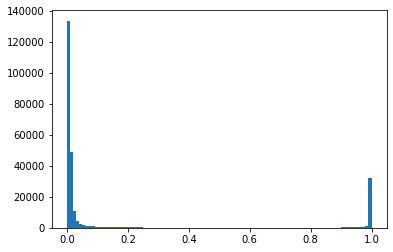

In [26]:
plt.hist(tf.reshape(new_preds, (-1)), bins=100);

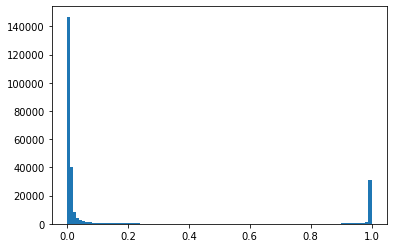

In [29]:
plt.hist(tf.reshape(tf.nn.sigmoid(preds), (-1)), bins=100);